# ESDA with pyGeoDa

For exploratory spatial data analysis (ESDA), pygeoa provides some
utility functions to allow users to easily work with geopandas and
matplotlib to visualize the results and do exploratory spatial data
analysis.


In this notebook, you will learn how to do ESDA with `pygeoda`, `geopandas` and `matplotlib`/`geoplot`.

## 1. Install GeoPandas and Matplotlib

### 1.1 GeoPandas
geopandas is a python library that allow users to work with geospatial data in Python. It is an extension of `pandas` python library by supporting `GeoSeries` type to allow spatial operations on geometric types besides traditional data manipulation and analysis.

geopandas  can be installed using conda or pip:
```
pip install geopandas
```

> Note: there are many dependencies of geopandas, so please check it's [documentation](http://geopandas.org/install.html) if encounting any issues.
* numpy
* pandas (version 0.19.1 or later)
* shapely (interface to GEOS)
* fiona (interface to GDAL)
* pyproj (interface to PROJ)
* six

geopandas can read geospatial data by using it's `read_file()` function, e.g.:
```Python
gdf = geopandas.read_file("/path/to/Guerry.shp")
```

Depending on the installation of GDAL library on your machine, the geospatial formats supported by geopandas varies. However, geopandas can be created using a GDAL datasource:
```Python
import ogr, geopandas
ds = ogr.Open('data_path')
lyr = ds[0]
gdf = geopandas.GeoDataFrame(lyr)
```
Using this approach, geopandas could load any geospatial data that is supported by GDAL literally. 

### 1.2 Matplotlib
Matplotlib is a Python 2D plotting library for making plots and maps. geopandas provides functions to directly call interfaces of Matplotlib to visualize maps, e.g. `geodataframe.plot(column='')`.

matplotlib can be installed using conda or pip:
```shell
pip install matplotlib
```

>Note: if there is error: "ImportError: The descartes package is required for plotting polygons in geopandas." Install descartes will solve this problem: 
```shell
pip install descartes
```

## 2. Start from GeoPandas

geopandas has been an essential python library to handle geospatial data, apply spatial operations and visualize maps. It is becoming an entry point of the spatial data analysis. A typical workflow of spatial data analysis in python could be beginning with geopandas: either load a geospatial data (e.g. ESRI shapefile) using geopandas, or create a geopandas dataframe from raw data like spreadsheets, databases etc. The geodataframe is then used to do spatial data analysis, store the results of data analysis, and finally visualize the results in terms of plots and maps using matplotlib. 

![workflow](https://github.com/lixun910/images/blob/master/libgeoda/pygeoda_workflow.png?raw=true)

In this notebook, the geospatial dataset `Guerry` in ESRI Shapefile format will be used for demonstration. You can download this dataset at: https://geodacenter.github.io/data-and-lab/Guerry/

### 2.1 Load geospatial data in GeoPandas
To load this geospatial data in GeoPandas:

In [1]:
import geopandas

gdf = geopandas.read_file("./data/Guerry.shp")

Then, you will get an instance of geodataframe: `gdf`.
You can check the meta data and content of this geodataframe

In [2]:
print(gdf.columns)
print(gdf.crs)

Index(['CODE_DE', 'COUNT', 'AVE_ID_', 'dept', 'Region', 'Dprtmnt', 'Crm_prs',
       'Crm_prp', 'Litercy', 'Donatns', 'Infants', 'Suicids', 'MainCty',
       'Wealth', 'Commerc', 'Clergy', 'Crm_prn', 'Infntcd', 'Dntn_cl',
       'Lottery', 'Desertn', 'Instrct', 'Prsttts', 'Distanc', 'Area',
       'Pop1831', 'geometry'],
      dtype='object')
{'init': 'epsg:27572'}


You can simply call function `plot()` to render the geospatial data as a map on a plot (matplotlib):

In [3]:
gdf.plot()

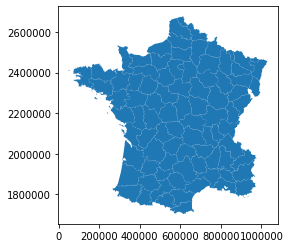

In [4]:
gdf.plot()

### 2.2 Create pygeoda object from geodataframe

pygeoda provides a utility function `geopandas_to_geoda` to easily create a pygeoda instance for spatial data analysis:

In [5]:
import pygeoda
guerry = pygeoda.geopandas_to_geoda(gdf)

> Note: the conversion is based on using Well-Known-Binary (WKB) format to exchange geometric data for good performance.

The function `geopandas_to_geoda()` returns an object of `GeoDa` class, which can be then used to access GeoDa functions to do spatial data analysis. For example, to examine the local Moran of variable “crm_prs” (Population per Crime against persons), we first create a Queen contiguity weights:



In [6]:
queen_w = pygeoda.weights.queen(guerry)
print(queen_w)

Weights Meta-data:

is symmetric:True
sparsity:0.0
density:5.813148788927336
min neighbors:2
mean neighbors:4.9411764705882355
median neighbors:5.0
max neighbors:8


### 2.3 ESDA with pygeoda and geopandas

#### 2.3.1 Local Moran Cluster Map

Now, with the geoda object `guerry`, you can call pygeoda’s spatial
analysis functions. For example, to examine the local Moran statistics
of variable “crm_prs” (Population per Crime against persons):

In [11]:
crm_prp = gdf.Crm_prp.to_list()
crm_lisa = pygeoda.local_moran(queen_w, crm_prp)

Now, with the LISA results, we can do exploratory spatial data analysis
by generating a LISA cluster map:

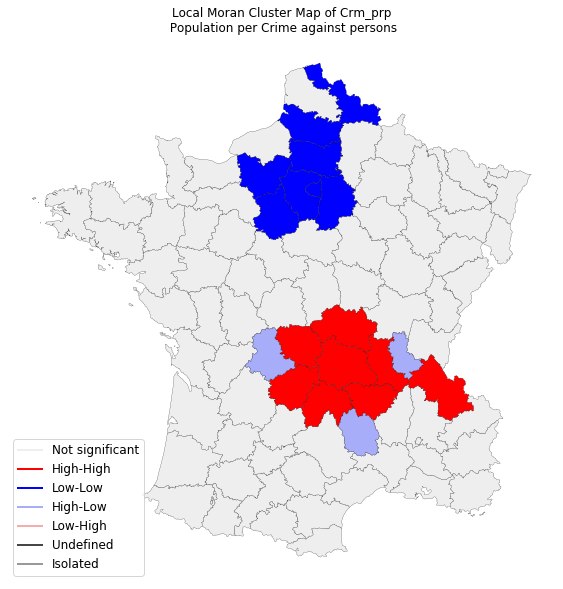

In [23]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,10))
lisa_colors = crm_lisa.GetColors()
lisa_labels = crm_lisa.GetLabels()

# attach LISA cluster indicators to geodataframe
gdf['LISA'] = crm_lisa.GetClusterIndicators()

for ctype, data in gdf.groupby('LISA'):
    color = lisa_colors[ctype]
    lbl = lisa_labels[ctype]
    data.plot(color = color, 
              ax = ax, 
              label = lbl, 
              edgecolor = 'black', 
              linewidth = 0.2)

# Place legend in the lower right hand corner of the plot
lisa_legend = [matplotlib.lines.Line2D([0], [0], color=color, lw=2) \
               for color in lisa_colors]
ax.legend(lisa_legend, lisa_labels, loc='lower left', fontsize=12, frameon=True)
ax.set(title='Local Moran Cluster Map of Crm_prp\n Population per Crime against persons')
ax.set_axis_off()

From the above code, you can see that we still use `gpf` object to do
plotting. The values of cluster indicators from pygeoda’s `crm_lisa` object
are used to make the LISA map.This emphasis that pygeoda is a API focused
library, which only provides the core functions of spatial data analysis
for easy integration.

If you check the values of the cluster indicators, you will see they are
integer numbers 0 (not significant), 1 (high-high cluster),
2 (low-low cluster), 3 (low-high cluster), 4 (high-low cluster),
5 (neighborless/island), 6 (undefined), which are excatly the same with
GeoDa software when you save LISA results to a table.

To create a siginificant map that is associated with the Local Moran map:


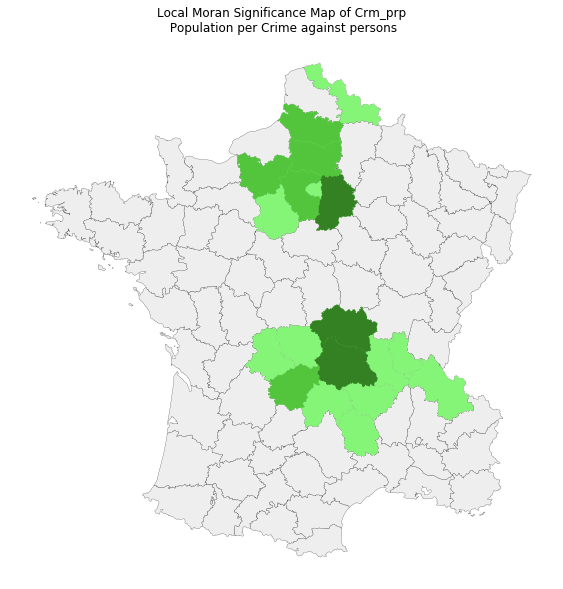

In [22]:
gdf['LISA_PVAL'] = crm_lisa.GetPValues()

fig, ax = plt.subplots(figsize = (10,10))

gdf.plot(color='#eeeeee', ax=ax, edgecolor = 'black', linewidth = 0.2)
gdf[gdf['LISA_PVAL'] <= 0.05].plot(color="#84f576", ax=ax)
gdf[gdf['LISA_PVAL'] <= 0.01].plot(color="#53c53c", ax=ax)
gdf[gdf['LISA_PVAL'] <= 0.001].plot(color="#348124", ax=ax)

ax.set(title='Local Moran Significance Map of Crm_prp\n Population per Crime against persons')

ax.set_axis_off()

#### 2.3.2 Local Geary Cluster Map

Another example is to create a map of local Geary:


In [24]:
crm_geary = pygeoda.local_geary(queen_w, crm_prp)

Then, use matplotlib to create a local geary map:

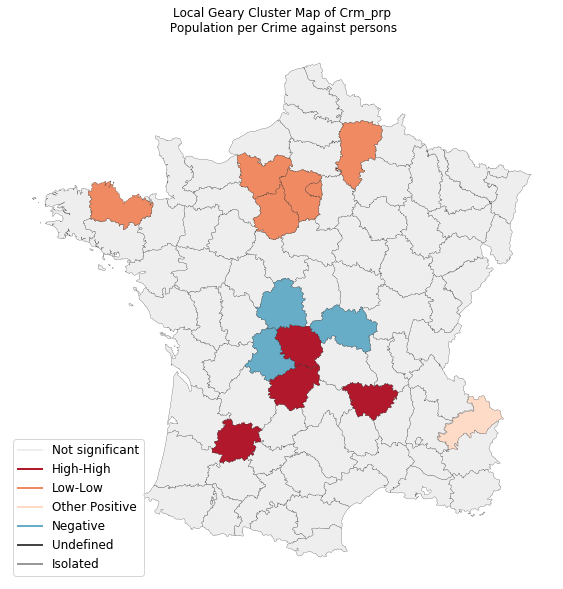

In [26]:
fig, ax = plt.subplots(figsize = (10,10))
lisa_colors = crm_geary.GetColors()
lisa_labels = crm_geary.GetLabels()

# attach LISA cluster indicators to geodataframe
gdf['GEARY'] = crm_geary.GetClusterIndicators()

for ctype, data in gdf.groupby('GEARY'):
    color = lisa_colors[ctype]
    lbl = lisa_labels[ctype]
    data.plot(color = color,
        ax = ax,
        label = lbl,
        edgecolor = 'black',
        linewidth = 0.2)
    
# Place legend in the lower right hand corner of the plot
lisa_legend = [matplotlib.lines.Line2D([0], [0], color=color, lw=2) for color in lisa_colors]
ax.legend(lisa_legend, lisa_labels,loc='lower left', fontsize=12, frameon=True)
ax.set(title='Local Geary Cluster Map of Crm_prp\n Population per Crime against persons')
ax.set_axis_off()

#### 2.3.3 Local G Cluster Map

To create a map of local Getis-Order G:

In [27]:
crm_g = pygeoda.local_g(queen_w, crm_prp)

Then, use matplotlib to create a local geary map:

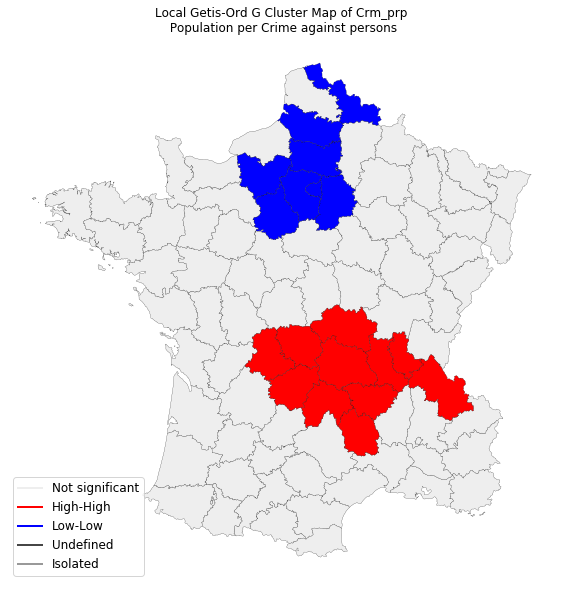

In [28]:
fig, ax = plt.subplots(figsize = (10,10))
lisa_colors = crm_g.GetColors()
lisa_labels = crm_g.GetLabels()

# attach LISA cluster indicators to geodataframe
gdf['GO'] = crm_g.GetClusterIndicators()

for ctype, data in gdf.groupby('GO'):
    color = lisa_colors[ctype]
    lbl = lisa_labels[ctype]
    data.plot(color = color,
        ax = ax,
        label = lbl,
        edgecolor = 'black',
        linewidth = 0.2)

# Place legend in the lower right hand corner of the plot
lisa_legend = [matplotlib.lines.Line2D([0], [0], color=color, lw=2) for color in lisa_colors]
ax.legend(lisa_legend, lisa_labels,loc='lower left', fontsize=12, frameon=True)
ax.set(title='Local Getis-Ord G Cluster Map of Crm_prp\n Population per Crime against persons')
ax.set_axis_off()

#### 2.2.3.4  SKATER  map


To create a map of SKATER clustering results, we first run skater clustering
on the data of 6 selected variables


In [31]:
select_vars = ["Crm_prs", "Crm_prp", "Litercy", "Donatns", "Infants", "Suicids"]
data = [guerry.GetRealCol(v) for v in select_vars]
skater_clusters = pygeoda.skater(4, queen_w, data)
print(skater_clusters)

((15, 74, 16, 55, 60, 39, 68, 33, 17, 82, 81, 0, 2, 40, 20, 80), (46, 50, 34, 38, 69, 47, 58, 19, 32, 41, 53, 26), (23, 79, 3, 29, 61, 21, 44, 11, 28, 13, 30, 35, 76, 77, 43, 9, 27, 45, 31, 78, 4, 10, 66, 37, 5, 14, 7, 63, 62), (49, 52, 72, 84, 8, 57, 56, 59, 42, 1, 25, 51, 48, 54, 64, 75, 18, 83, 73, 36, 24, 71, 6, 67, 65, 70, 22, 12))


The results of the `skater()` function is a 2d list that represents
groups of clusters. For plotting, we first flat this 2d list to a 1d list
that each element has a value representing which cluster this element
belongs to:

In [37]:
def flat_2dcluster(clusters):
    num_obs = sum(len(c) for c in clusters)
    flat_cluster = [0] * num_obs
    for cid, cluster in enumerate(clusters):
        for idx in cluster:
            flat_cluster[idx] = cid
    return flat_cluster

To make a plot using matplotlib:

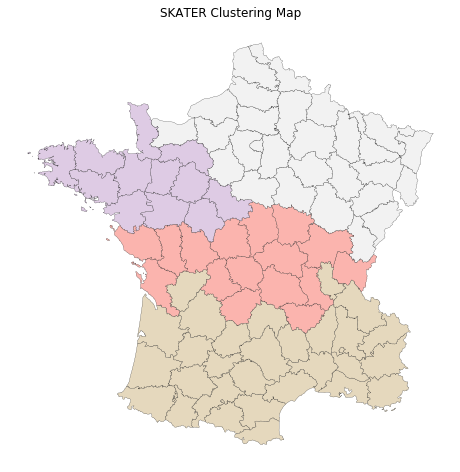

In [38]:
gdf['SKATER_C'] = flat_2dcluster(skater_clusters)
fig, ax = plt.subplots(figsize = (8,10))
gdf.plot(column="SKATER_C", ax=ax, edgecolor = 'black', linewidth = 0.2, cmap="Pastel1")
ax.set(title="SKATER Clustering Map")
ax.set_axis_off()

#### 2.2.3.5 Max-p  Map

To make a map of Max-p clustering results, we first run skater clustering
on the data of 6 selected variables:

In [40]:
bound_vals = gdf.Pop1831.to_list()
min_bound = 3236.67 # 10% of Pop1831
maxp_clusters = pygeoda.maxp(queen_w, data, bound_vals, min_bound, "greedy")
print(maxp_clusters)

((13, 31, 5, 45, 11, 79, 27, 78, 23, 4, 3, 43, 35, 66, 44, 30), (34, 16, 33, 55, 46, 69, 58, 47, 50, 38), (77, 9, 7, 28, 62, 29, 37, 61, 63, 10, 76), (67, 65, 83, 64, 54, 52, 51, 22, 48, 8), (0, 68, 60, 40, 2, 39, 20, 17, 21, 14), (25, 42, 24, 73, 70, 12, 71), (75, 56, 6, 1, 59, 18, 57, 72, 49, 36, 84), (80, 41, 32, 26, 19, 53, 74, 81, 15, 82))


To make a plot using matplotlib:


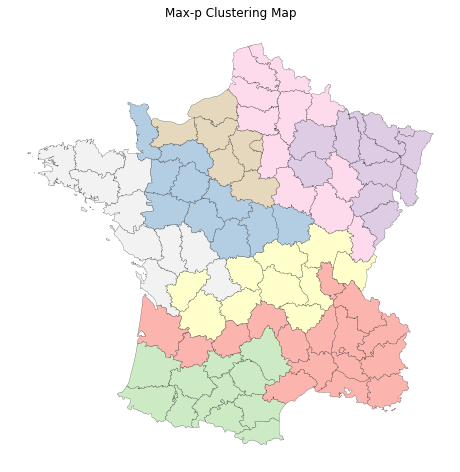

In [42]:
gdf['MAXP_C'] = flat_2dcluster(maxp_clusters)
fig, ax = plt.subplots(figsize = (8,10))
gdf.plot(column="MAXP_C", ax=ax, edgecolor = 'black', linewidth = 0.2, cmap="Pastel1")
ax.set(title="Max-p Clustering Map")
ax.set_axis_off()